In [ ]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import pathlib
import scipy
import warnings
from tqdm import tqdm
import dask.dataframe as dd

warnings.filterwarnings("ignore")
sns.set()
from cellesce import Cellesce

# plt.ion()

VARIABLES = ["Conc /uM", "Date", "Drug"]
SAVE_FIG = True
SAVE_CSV = True
TEST_ROT = False

# data_folder = "analysed/210720 - ISO49+34 - projection_XY/unet_2022/project_XY_all"
# data_folder = "analysed/210720 - ISO49+34 - projection_XY/unet_2022/project_XY_objects"

# pd.read_csv("analysed/_2019_cellesce_unet_splineparameters_aligned/raw/projection_XY/Secondary.csv")

kwargs = {
    "data_folder": "analysed/210720 - ISO49+34 - projection_XY/unet_2022/project_XY_all",
    "nuclei_path": "object_filteredNuclei.csv",
}
kwargs = {
    "data_folder": "analysed/210720 - ISO49+34 - projection_XY/unet_2022/project_XY_objects",
    "nuclei_path": "Secondary.csv",
}


kwargs = {
    "data_folder": "analysed/_2019_cellesce_unet_splineparameters_aligned/raw/projection_XY/",
    "nuclei_path": "Secondary.csv",
}


kwargs = {
    "data_folder": "analysed/_2019_cellesce_unet_splineparameters_aligned/raw/projection_XY/",
    "nuclei_path": "Secondary.csv",
}

kwargs_cellprofiler = {
    "data_folder": "analysed/210720 - ISO49+34 - projection_XY/unet_2022/project_XY_objects",
    "nuclei_path": "object_filteredNuclei.csv",
}


# kwargs_splinedist = {
#     "data_folder": "analysed/cellprofiler",
#     "nuclei_path": "objects_FilteredNuclei.csv",
# }


kwargs_splinedist = {
    "data_folder": "analysed/cellesce_splinedist_controlpoints",
    "nuclei_path": "Secondary.csv",
}

kwargs_splinedist = {
    "data_folder": "old_results/control_points",
    "nuclei_path": "objects_FilteredNuclei.csv",
}

# kwargs_cellprofiler = {
#     "data_folder": "analysed/cellprofiler/splinedist",
#     "nuclei_path": "objects_FilteredNuclei.csv",
# }


kwargs_cellprofiler = {
    "data_folder": "old_results/analysed/cellprofiler/splinedist",
    "nuclei_path": "objects_FilteredNuclei.csv",
}

In [ ]:
# kwargs_cellprofiler = {
#     "data_folder": "analysed/cellprofiler/splinedist_32",
#     "nuclei_path": "objects_FilteredNuclei.csv",
# }

kwargs = kwargs_splinedist
kwargs = kwargs_cellprofiler


def save_csv(df, path):
    df.to_csv(metadata(path))
    return df


results_folder = f"results/merged"
pathlib.Path(results_folder).mkdir(parents=True, exist_ok=True)


def metadata(x):
    path = pathlib.Path(results_folder, x)
    print(path)
    return path

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
from cellesce import Cellesce
import cellesce.shapes as shapes

df_splinedist = (
    Cellesce(**kwargs_splinedist)
    .get_data()
    .apply(shapes.align_coords_to_origin_np, axis=1, raw=True)
    .cellesce.preprocess()
    .cellesce.clean()
    .assign(Features="SplineDist")
    .set_index(["Features"], append=True)
    # .apply(shapes.align_coords_to_origin_np, axis=1, raw=True)
    .sample(frac=1)
)
df_splinedist

In [ ]:

x = df_splinedist.iloc[:, np.arange(0, len(df_splinedist.columns) - 1, 2)]
y = df_splinedist.iloc[:, np.arange(1, len(df_splinedist.columns), 2)]
plt.figure()
plt.scatter(x.iloc[0], y.iloc[0])
if not TEST_ROT:
    plt.close()

In [ ]:
df_splinedist_rot = df_splinedist.apply(
    shapes.rotate_control_points_np, theta=-np.pi / 2, axis=1, raw=True
)

x = df_splinedist_rot.iloc[:, np.arange(0, len(df_splinedist.columns) - 1, 2)]
y = df_splinedist_rot.iloc[:, np.arange(1, len(df_splinedist.columns), 2)]
plt.figure()
plt.scatter(x.iloc[0], y.iloc[0])
if not TEST_ROT:
    plt.close()

In [ ]:
# # %%
# # %%
# # distogram.flatten()
# # distogram = sklearn.metrics.pairwise.euclidean_distances(df.iloc[[0]].T)
# df_sorted = df_splinedist.reindex(
#     np.array(sorted(df_splinedist.columns.astype(np.int))).astype(np.str), axis=1
# )
# df_dist = df_sorted.apply(
#     lambda x: euclidean_distances(np.array(x).reshape(-1, 1)).flatten(),
#     axis=1,
#     result_type="expand",
# )
# # %%
# euclid = euclidean_distances(np.array(df_sorted.iloc[0]).reshape(-1, 1))

# # %%

# df_dist = df_sorted.apply(
#     lambda x: euclidean_distances(np.array([x[0::2], x[1::2]]).T).flatten(),
#     axis=1,
#     result_type="expand",
# )


# df_dist.columns = df_dist.columns.astype(str)
# # df_dist = (df_sorted
# #             .apply(lambda x: euclidean_distances(np.array([x[0::2],x[1::2]]).T,[[0,0]])
# #             .flatten(),axis=1,result_type="expand"))
# df_splinedist = df_dist
# rows, features = df_splinedist.shape

df_cellprofiler = (
    Cellesce(**kwargs_cellprofiler)
    .get_data()
    .cellesce.preprocess()
    .cellesce.clean()
    .assign(Features="CellProfiler")
    .set_index(["Features"], append=True)
    # .sample(32,axis=1,random_state=42)
)
df_cellprofiler.columns = df_cellprofiler.columns.str.replace("AreaShape_", "")
df = pd.concat([df_cellprofiler, df_splinedist])


pca_spline = PCA(n_components=0.99).fit(df_splinedist)
pca_cellprofiler = PCA(n_components=0.99).fit(df_cellprofiler)

# pd.DataFrame(pca_spline.explained_variance_, columns=["Explained Variance"]).assign(
#     **{
#         "Features": "Control points",
#         "Principal Component": np.arange(0, len(pca_spline.explained_variance_)),
#     }
# )


exp_var = pd.concat(
    [
        pd.DataFrame(
            pca_spline.explained_variance_, columns=["Explained Variance"]
        ).assign(
            **{
                "Features": "Control points",
                "Principal Component": np.arange(
                    0, len(pca_spline.explained_variance_)
                ),
            }
        ),
        pd.DataFrame(
            pca_cellprofiler.explained_variance_, columns=["Explained Variance"]
        ).assign(
            **{
                "Features": "CellProfiler",
                "Principal Component": np.arange(
                    0, len(pca_cellprofiler.explained_variance_)
                ),
            }
        ),
    ]
)

pca_component = pd.concat(
    [
        pd.DataFrame(pca_spline.components_, columns=df_splinedist.columns).assign(
            **{
                "Features": "Control points",
                "Principal Component": np.arange(0, len(pca_spline.components_)),
            }
        ),
        pd.DataFrame(
            pca_cellprofiler.components_, columns=df_cellprofiler.columns
        ).assign(
            **{
                "Features": "CellProfiler",
                "Principal Component": np.arange(0, len(pca_cellprofiler.components_)),
            }
        ),
    ]
).set_index(["Features", "Principal Component"])

results/merged/pca.pdf


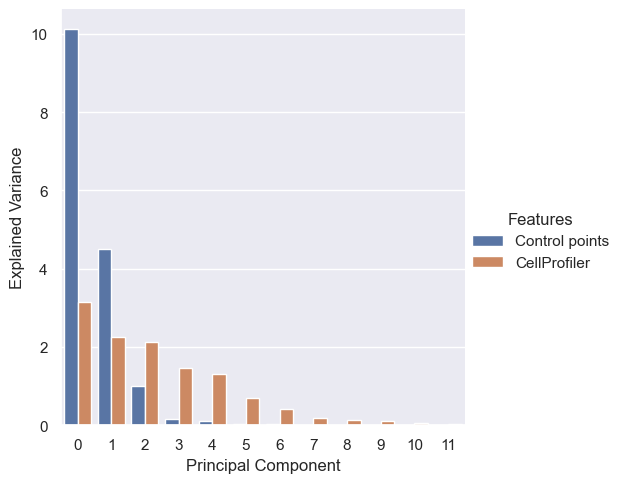

In [7]:
# plt.figure()
sns.catplot(
    x="Principal Component",
    hue="Features",
    y="Explained Variance",
    data=exp_var,
    legend_out=True,
    kind="bar",
)
plt.savefig(metadata("pca.pdf"), bbox_inches="tight")

In [ ]:
component_melt = pd.melt(
    pca_component,
    var_name="Feature",
    value_name="Component Magnitude",
    ignore_index=False,
).set_index(["Feature"], append=True)


important_features = (
    component_melt.transform(abs)
    .reset_index()
    .sort_values("Component Magnitude", ascending=False)
    .drop_duplicates(["Features", "Principal Component"])
    .sort_values("Principal Component")
)

In [ ]:
# sns.catplot(
#     x="Principal Component",
#     y="Feature",
#     data=important_features.reset_index(),
#     col="Features",
#     sharey=False,
# )

In [ ]:

# sns.catplot(
#     col="Principal Component",
#     y="Feature",
#     x="Component Magnitude",
#     sharey=False,
#     data=component_melt.reset_index(),
#     row="Features",
#     height=12,
# )

In [ ]:
# df = df.iloc[:,random.sample(range(0, features), 32)]

print(
    f'Organoids: {df.cellesce.grouped_median("ObjectNumber").cellesce.simple_counts()}',
    f"Nuclei: {df.cellesce.simple_counts()}",
)

upper = np.nanmean(df.values.flatten()) + 2 * np.nanstd(df.values.flatten())
lower = np.nanmean(df.values.flatten()) - 2 * np.nanstd(df.values.flatten())


def df_to_fingerprints_facet(*args, **kwargs):
    data = kwargs.pop("data")
    data = data.drop([*args[2:]], 1)

    image = data.dropna(axis=1, how="all")

    rows, cols = image.shape
    median_height = 0.1
    gap_height = 0.15
    # median_rows = int(rows*median_height/100)
    image_rows_percent = 1 - (gap_height + median_height)
    one_percent = rows / image_rows_percent
    # print(one_percent,rows)
    gap_rows = int(gap_height * one_percent)
    median_rows = int(median_height * one_percent)

    # median_rows,gaps_rows=(rows,rows)
    finger_print = image.median(axis=0)

    finger_print_image = np.matlib.repmat(finger_print.values, median_rows, 1)
    all_data = np.vstack([image, np.full([gap_rows, cols], np.nan), finger_print_image])

    # fig,ax = plt.subplots(figsize=(5,3), dpi=150)
    # fig, ax = plt.figure(figsize=(5,3), dpi=150)
    # plt.figure()
    plt.imshow(all_data, vmin=lower, vmax=upper, cmap="Spectral")
    # sns.heatmap(all_data,vmin=lower, vmax=upper, cmap="Spectral",interpolation='nearest')
    fig, ax = (plt.gcf(), plt.gca())
    ax.set(adjustable="box", aspect="auto", autoscale_on=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_facecolor("white")
    ax.grid(False)
    # fig.add_subplot(2,2,1)


sns.set()
g = sns.FacetGrid(
    df.reset_index(level=["Cell", "Features"]),
    col="Features",
    row="Cell",
    height=2,
    aspect=1.61,
    sharey=False,
    sharex=False,
)
cax = g.fig.add_axes([1.015, 0.13, 0.015, 0.8])
g.map_dataframe(
    df_to_fingerprints_facet,
    "Features",
    "Nuclei",
    "Features",
    "Cell",
    cmap="Spectral",
    cbar=True,
    vmax=upper,
    vmin=lower,
)
plt.colorbar(cax=cax)
plt.savefig(metadata("fingerprints.pdf"), bbox_inches="tight")
# plt.show();plt.close()

In [ ]:


# df_distance_matrix = (df_splinedist
#                       .pipe(df_to_distance_matrix)
#                       .pipe(augment_distance_matrix,axis=1))


# df = pd.concat([df_cellprofiler, df_splinedist])

# df = pd.concat([df_cellprofiler,
#                 df_splinedist.pipe(df_to_distance_matrix)])


# df = pd.concat([df_cellprofiler
#                     .pipe(augment_repeat, fold=1),
#                 df_splinedist
#                     .pipe(df_to_distance_matrix)
#                     .pipe(augment_distance_matrix)
#                     .pipe(df_add_augmentation_index)])

In [ ]:
# TODO

In [ ]:


def feature_importances(df, augment=None):
    return (
        df.cellesce.grouped_median("ObjectNumber")
        .dropna(axis=1)
        .cellesce.feature_importances(variable="Cell", kfolds=10, augment=augment)
    ).assign(Augmentation=augmentation)


def scoring(df, augment=None):
    return (
        df.cellesce.grouped_median("ObjectNumber")
        .dropna(axis=1)
        .cellesce.get_scoring_df(variable="Cell", kfolds=10, augment=augment)
    ).assign(Augmentation=augmentation)


importance_list = []
scoring_list = []

for augmentation in tqdm([0, 250, 500, 1000]):

    # for fold in range(1,6):

    # df = pd.concat(
    #     [
    #         df_cellprofiler.pipe(augment_repeat, fold=fold).pipe(df_add_augmentation_index),
    #         df_splinedist.pipe(augment_df, rotate_control_points, fold=fold).pipe(
    #             df_add_augmentation_index
    #         ),
    #     ]
    # )
    # df = pd.concat(
    #     [
    #         df_cellprofiler.pipe(df_add_augmentation_index),
    #         df_splinedist.pipe(augment_df, rotate_control_points, fold=augmentation)
    #         # .pipe(df_add_augmentation_index),
    #     ]
    # )
    # dask_spline_df = dd.from_pandas(df_splinedist.reset_index(),npartitions=1)

    # temp_df = df_splinedist.cellesce.grouped_median("ObjectNumber")
    # temp_df.loc[:,:] = 1
    # df = pd.concat(
    #     [
    #         # df_splinedist.pipe(rotate_control_points,fold=10)
    #         df_cellprofiler.pipe(df_add_augmentation_index),
    #         df_splinedist.pipe(augment_df, rotate_control_points_np, fold=augmentation),
    #         # .pipe(df_add_augmentation_index),
    #     ]
    # )
    # df = pd.concat(
    #     [
    #         # df_splinedist.pipe(rotate_control_points,fold=10)
    #         df_cellprofiler,
    #         df_splinedist
    #         # .pipe(df_add_augmentation_index),
    #     ]
    # )
    # df_cellprofiler_rep = df_cellprofiler.reindex(df_cellprofiler.index.repeat(3)).pipe(
    #     df_add_augmentation_index
    # )

    # df = df_cellprofiler_rep
    # feature_importance = df.groupby(level="Features").apply(
    #     lambda df: df.cellesce.grouped_median("ObjectNumber")
    #     .dropna(axis=1)
    #     .cellesce.feature_importances(variable="Cell",kfolds=5,groupby="augmentation")
    # ).assign(Augmentation=augmentation)

    spline_augment = lambda X, y: shapes.angular_augment_X_y(
        X, y, shapes.rotate_control_points_np, fold=augmentation
    )

    # df_splinedist.pipe(feature_importances,augment=spline_augment)

    # feature_importance_df = pd.concat(
    #     [df_cellprofiler.pipe(feature_importances),
    #      df_splinedist.pipe(feature_importances,augment=angular_augment_X_y)])
    # TODO this isnt augmenting
    feature_importance_df = pd.concat(
        [
            (
                df_cellprofiler.cellesce.grouped_median("ObjectNumber")
                .pipe(feature_importances)
                .assign(Features="CellProfiler")
                .set_index("Features", append=True)
            ),
            (
                df_splinedist.cellesce.grouped_median("ObjectNumber")
                .pipe(
                    feature_importances,
                    augment=shapes.angular_augment_X_y_fun(fold=augmentation),
                )
                .assign(Features="SplineDist")
                .set_index("Features", append=True)
            ),
        ]
    )

In [ ]:
    scoring_df = pd.concat(
        [
            (
                df_cellprofiler.cellesce.grouped_median("ObjectNumber")
                .pipe(scoring)
                .assign(Features="CellProfiler")
                .set_index("Features", append=True)
            ),
            (
                df_splinedist.cellesce.grouped_median("ObjectNumber")
                .pipe(scoring, augment=shapes.angular_augment_X_y)
                .assign(Features="SplineDist")
                .set_index("Features", append=True)
            ),
        ]
    )

    importance_list.append(feature_importance_df)
    scoring_list.append(scoring_df)

    # feature_importance = (
    #     df.groupby(level="Features").apply(
    #         lambda df: df.cellesce.grouped_median("ObjectNumber")
    #         .dropna(axis=1)
    #         .cellesce.feature_importances(
    #             variable="Cell", kfolds=10, groupby="augmentation"
    #         )
    #     )
    # ).assign(Augmentation=augmentation)

    # scoring = (
    #     df.groupby(level="Features").apply(
    #         lambda df: df.cellesce.grouped_median("ObjectNumber")
    #         .dropna(axis=1)
    #         .cellesce.get_scoring_df(variable="Cell", kfolds=10, groupby="augmentation")
    #     )
    # ).assign(Augmentation=augmentation)


scoring_df = pd.concat(scoring_list)
importance_df = pd.concat(importance_list)


scoring_df_mean = scoring_df.groupby(
    ["Augmentation", "Metric", "Kind", "Variable"]
).mean()
scoring_df_var = scoring_df.groupby(
    ["Augmentation", "Metric", "Kind", "Variable"]
).var()

results/merged/scoring.pdf


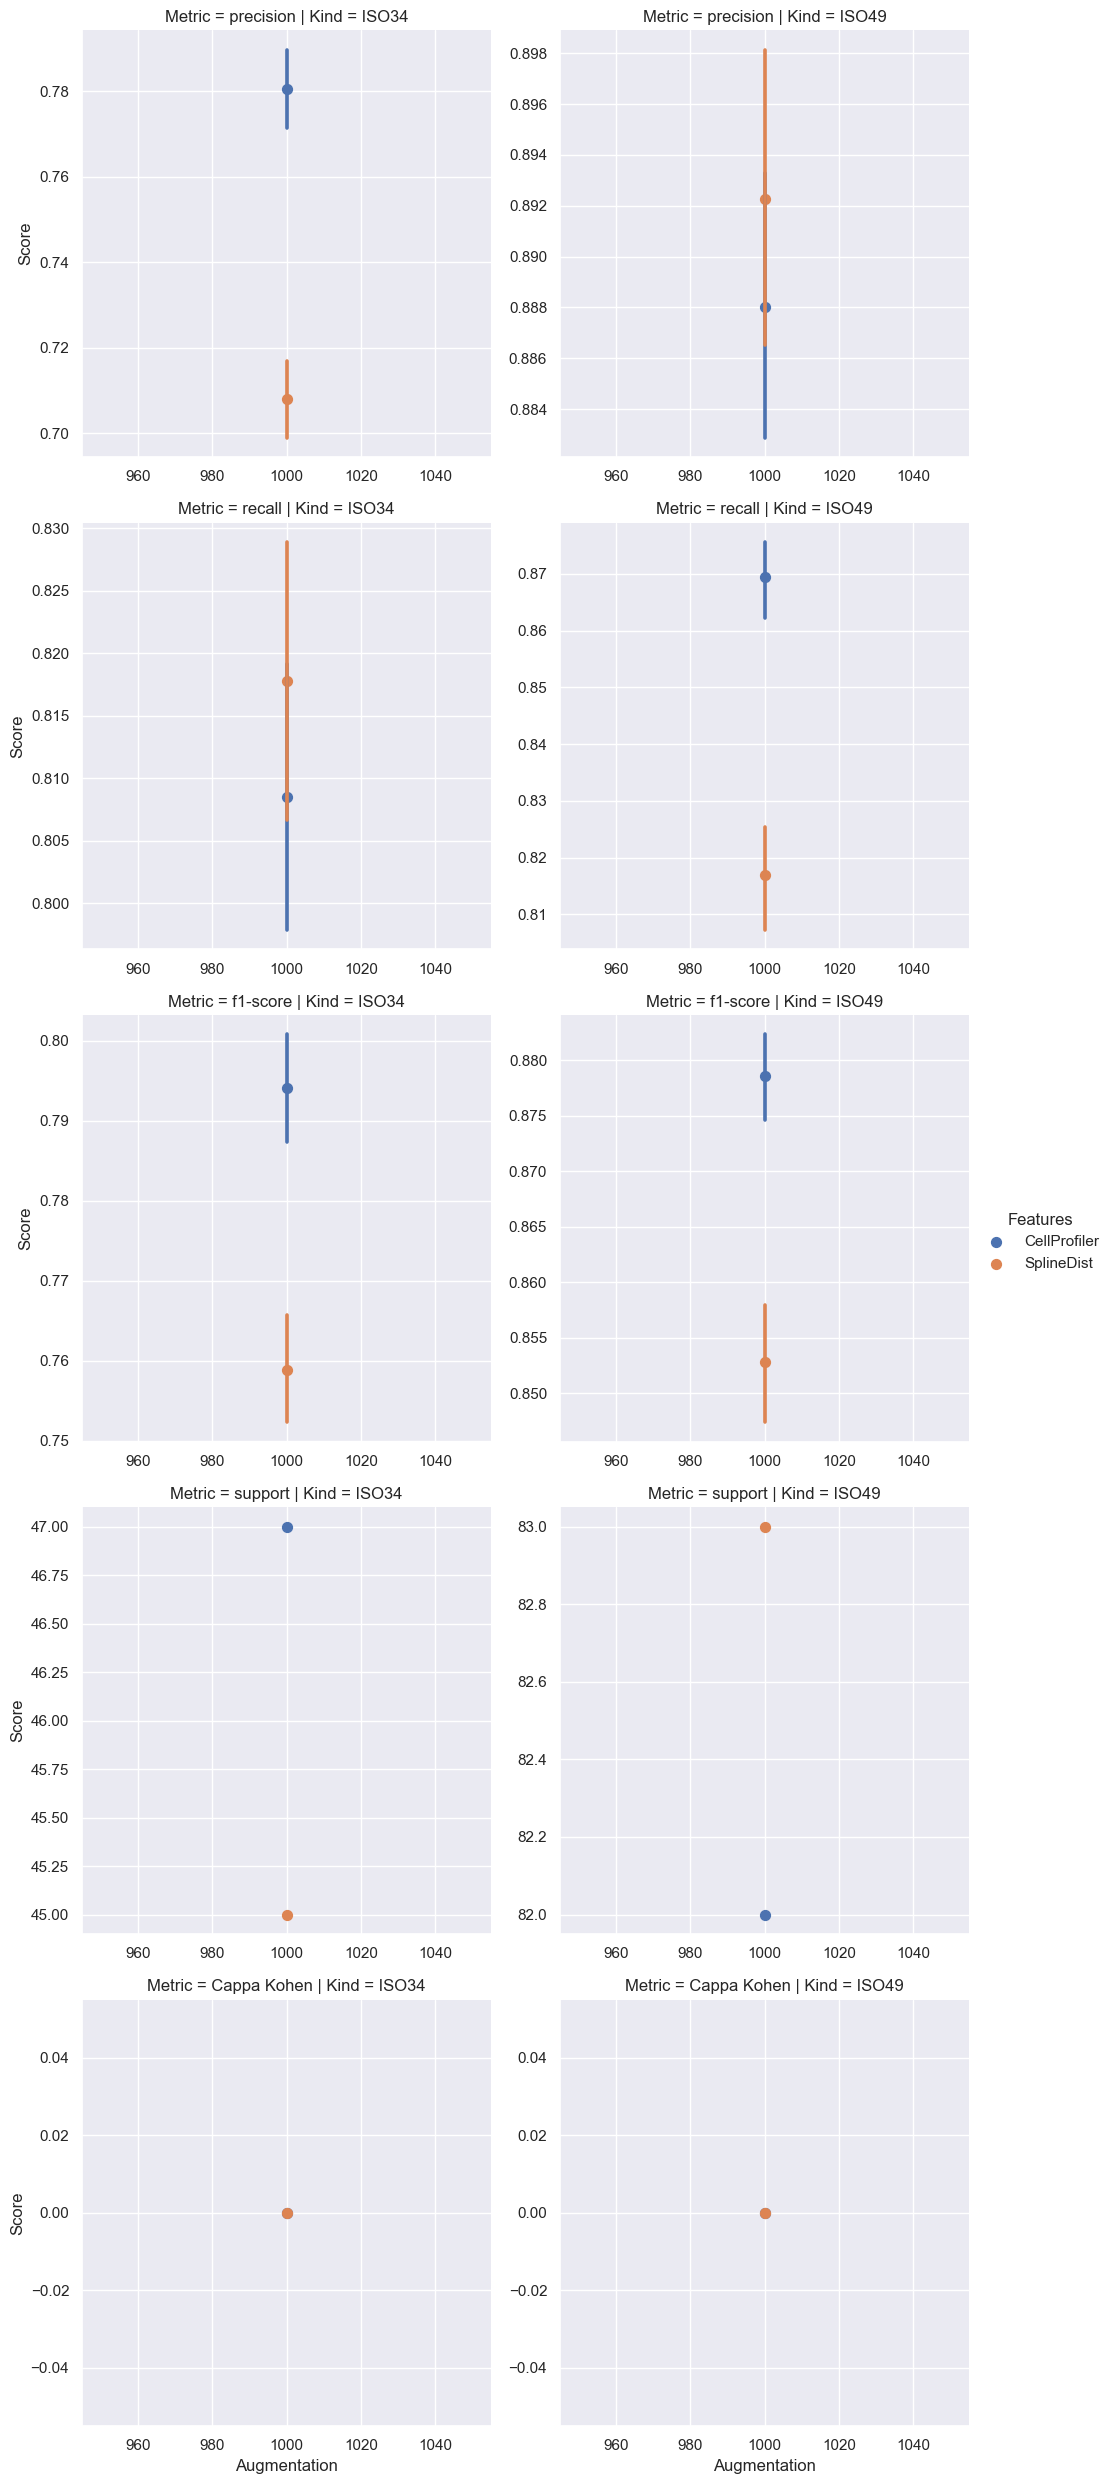

In [16]:
# data = scoring_df.reset_index("Features")
# data.to_csv("scoring_df.csv")
sns.lmplot(
    x="Augmentation",
    y="Score",
    col="Kind",
    row="Metric",
    hue="Features",
    fit_reg=False,
    sharey=False,
    sharex=False,
    x_ci="ci",
    x_bins=5,
    data=(scoring_df.reset_index("Features")),
)
plt.savefig(metadata("scoring.pdf"))

results/merged/feature_importance.pdf


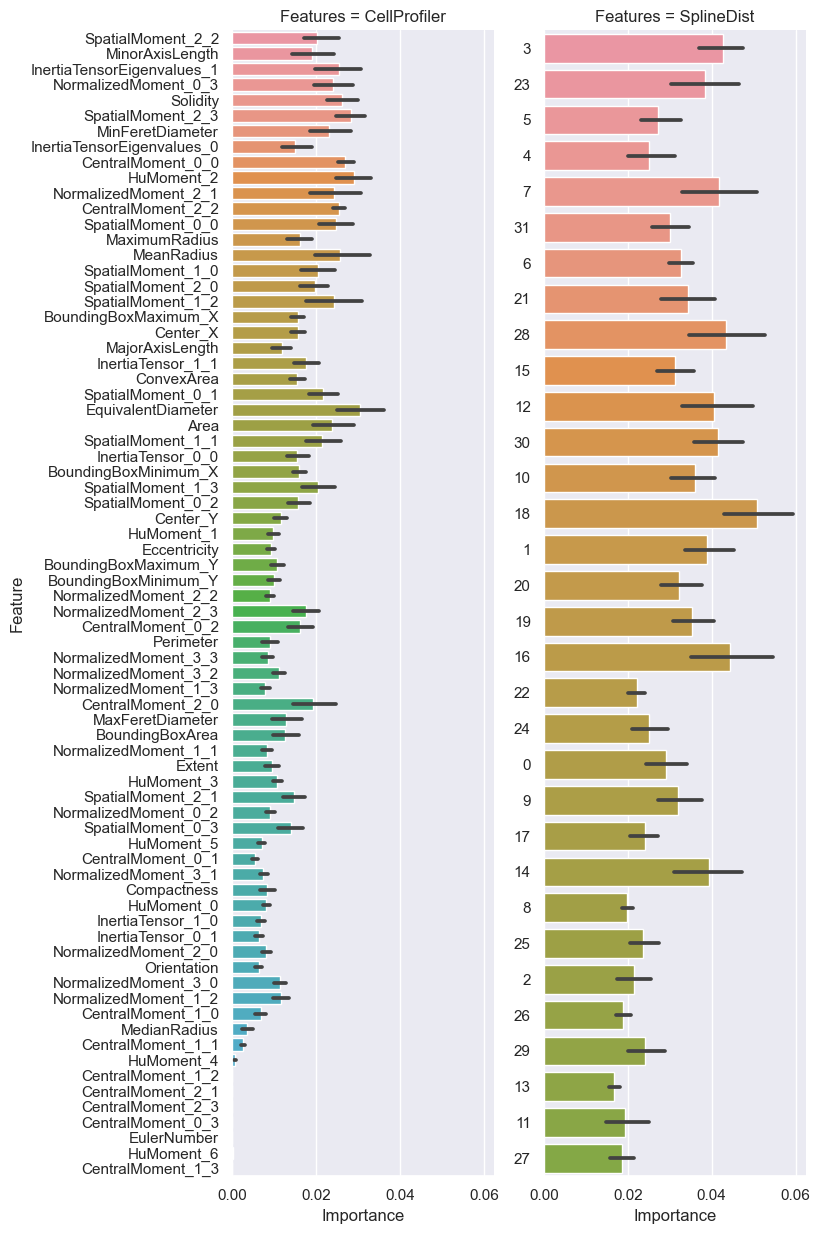

In [17]:
# plt.show();plt.close()

sns.catplot(
    y="Feature",
    x="Importance",
    col="Features",
    sharey=False,
    kind="bar",
    aspect=1 / 3,
    height=12.5,
    data=(importance_df.reset_index()),
)
plt.savefig(metadata("feature_importance.pdf"))

# plt.show();plt.close()

In [ ]:
# TODO figure how to add after data splitting

# df = (
#     df_cellprofiler.pipe(augment_repeat, fold=fold)
#     .pipe(df_add_augmentation_index)
#     .cellesce.grouped_median("ObjectNumber")
#     .dropna(axis=1)
# )

# df = (df_splinedist
#     .pipe(augment_df, rotate_control_points, fold=5)
#     .pipe(df_add_augmentation_index))

# groupby = list(set(df.index.names)-{"augmentation"})

# y = df.reset_index()[["Cell"]].astype(str)
# X_train, X_test, y_train, y_test = df.cellesce.train_test_split(
#     variable="Cell", groupby=["augmentation"], seed=42)
# # (RandomForestClassifier()
# #         .fit(X_train,
# #              y_train)
# #         .score(X_test.xs(0,level="augmentation"),
# #                y_test.xs(0,level="augmentation")))

# score = (RandomForestClassifier()
#         .fit(X_train,y_train)
#         .score(X_test,y_test))
# print(f"fold {fold} score {score}")

In [ ]:
data = (
    (
        df.groupby(level="Features").apply(
            lambda df: df.cellesce.grouped_median()
            .dropna(axis=1)
            .cellesce.feature_importances(variable="Cell")
        )
    )
    .reset_index()
    .pipe(save_csv, "importance_median_control_points.csv")
)
sns.catplot(
    y="Feature",
    x="Importance",
    col="Features",
    sharey=False,
    kind="bar",
    aspect=1 / 3,
    height=12.5,
    data=data,
)

# plt.tight_layout()
plt.savefig(metadata("importance_median_control_points.pdf"))

In [ ]:

# sample = -1

spline_importances = importance_df.xs("SplineDist", level="Features")["Importance"]

cellprofiler_importances = importance_df.xs("CellProfiler", level="Features")[
    "Importance"
]

spline_H = scipy.stats.entropy(
    spline_importances, qk=np.ones_like(spline_importances) / len(spline_importances)
)
spline_H

cellprofiler_H = scipy.stats.entropy(
    cellprofiler_importances,
    qk=np.ones_like(cellprofiler_importances) / len(cellprofiler_importances),
)
cellprofiler_H

# scipy.stats.ks_2samp(cellprofiler_importances,np.ones_like(cellprofiler_importances)/len(cellprofiler_importances))

# scipy.stats.ks_2samp(spline_importances,np.ones_like(spline_importances)/len(spline_importances))

spline_test = scipy.stats.normaltest(importance_df.xs("SplineDist", level="Features"))
cellprofiler_test = scipy.stats.normaltest(
    importance_df.xs("CellProfiler", level="Features")
)
print(f"Spline: {spline_H} CellProfiler: {cellprofiler_H}")
print(f"Spline: {spline_test.pvalue[0]} CellProfiler: {cellprofiler_test.pvalue[0]}")

In [ ]:
# sns.barplot(
#     y="Feature", x="Cumulative Importance",
#     data=df.cellesce.feature_importances(variable="Cell").reset_index()
# )
# plt.tight_layout()

In [ ]:
#     data=(
#         pd.concat(
#         [(
#             df.cellesce.grouped_median("ObjectNumber")
#             .cellesce.get_score_report("Cell")
#             .assign(**{"Population type": "Organoid"})
#             .set_index("Metric")
#             .loc[['f1-score', 'recall','precision']]
#             .reset_index()
#             .assign(Fold=fold)
#             .pipe(save_csv,"Cell_predictions_organoid.csv")
#             )
#         for fold in range(5)]
#     )),
# data =  pd.concat([
#         (pd.concat(
#         [
#             (
#                 (df.groupby(level="Features")
#                  .apply(lambda df:
#                     df.dropna(axis=1)
#                     .cellesce.get_score_report(variable="Cell")))
#                 .assign(**{"Population type": "Nuclei"})
#             ),
#             (
#                 (df.groupby(level="Features")
#                  .apply(lambda df:
#                     df.cellesce.grouped_median().dropna(axis=1)
#                     .cellesce.get_score_report(variable="Cell")))
#                 .assign(**{"Population type": "Organoid"})
#             ),
#         ])
#         .reset_index()
#         .set_index("Metric")
#         .loc[['f1-score', 'recall','precision']])
#         .reset_index()
#         .assign(Fold=fold) for fold in range(5)
#         ]).pipe(save_csv,"Cell_predictions_image_vs_nuclei.csv")

In [ ]:


# No augmentation
# df = pd.concat([df_cellprofiler, df_splinedist])

# Distance matrix method
# df = pd.concat([df_cellprofiler, df_splinedist.pipe(df_to_distance_matrix)])
# df = pd.concat(
#     [
#         df_cellprofiler.reindex(df_cellprofiler.index.repeat(100)).pipe(
#             df_add_augmentation_index
#         ),
#         df_splinedist.pipe(augment_df, rotate_control_points, fold=100).pipe(
#             df_add_augmentation_index
#         ),
#     ]
# )


# df_cellprofiler_rep = df_cellprofiler.reindex(df_cellprofiler.index.repeat(100)).pipe(df_add_augmentation_index)
# df_cellprofiler_rep.pipe(df_add_augmentation_index)

# pd.MultiIndex.from_arrays([df.index, df.groupby(level=0).cumcount()],
#                                      names=(list(df.index.names) + ["Augment"]))
# options = {
#     "raw": pd.concat([df_cellprofiler, df_splinedist]),
#     "distance_matrix": pd.concat(
#         [df_cellprofiler, df_splinedist.pipe(df_to_distance_matrix)]
#     ),
#     "angular_augment": pd.concat(
#         [
#             df_cellprofiler,
#             df_splinedist.pipe(augment_df, rotate_control_points, fold=10),
#         ]
#     ),
# }

# df = options["angular_augment"]


def get_score_report_per_level(df, level="Features"):
    return (
        df.groupby(level="Features")
        .apply(
            lambda df: df.cellesce.grouped_median()
            .dropna(axis=1)
            .cellesce.get_score_report(variable="Cell")
        )
        .reset_index()
        .set_index("Metric")
        .loc[["f1-score", "recall", "precision"]]
        .reset_index()
    )


(
    sns.catplot(
        aspect=1.2,
        height=3,
        x="Features",
        y="Score",
        col="Metric",
        row="Kind",
        # ci=None,
        data=df.pipe(shapes.get_score_report_per_level, "Features"),
        sharey=False,
        kind="bar",
    )
    .set_xticklabels(rotation=45)
    .set(ylim=(0, 1))
)

In [ ]:
df = pd.concat([df_cellprofiler, df_splinedist])


def score_report_per_row(df, variable="Cell"):
    return df.groupby(level="Features").apply(
        lambda df: df.dropna(axis=1).cellesce.get_score_report(variable=variable)
    )


def score_report_per_group(df, variable="Cell", group="ObjectNumber"):
    return df.groupby(level="Features").apply(
        lambda df: df.cellesce.grouped_median(group)
        .dropna(axis=1)
        .cellesce.get_score_report(variable=variable)
    )


def get_score_report_per_with_error(df, fold, variable="Cell"):
    return (
        pd.concat(
            [
                score_report_per_row(df, "Cell").assign(
                    **{"Population type": "Nuclei"}
                ),
                score_report_per_group(df, "Cell").assign(
                    **{"Population type": "Organoid"}
                ),
            ]
        )
        .reset_index()
        .set_index("Metric")
        .loc[["f1-score", "recall", "precision"]]
        .reset_index()
        .assign(Fold=fold)
    )


data_list = []
pbar = tqdm(range(5))
for fold in pbar:
    pbar.set_description(f"Folding:")
    data_list.append(get_score_report_per_with_error(df, fold))

data = pd.concat(data_list).pipe(save_csv, "Cell_predictions_image_vs_nuclei.csv")

In [ ]:
(
    sns.catplot(
        aspect=1.2,
        height=3,
        x="Kind",
        y="Score",
        col="Metric",
        row="Features",
        # ci=None,
        hue="Population type",
        data=data,
        sharey=False,
        kind="bar",
    )
    .set_xticklabels(rotation=45)
    .set(ylim=(0, 1))
)

# plt.tight_layout()
if SAVE_FIG:
    plt.savefig(metadata("Cell_predictions_image_vs_nuclei.pdf"))

(
    sns.catplot(
        aspect=1,
        height=3,
        x="Features",
        y="Score",
        col="Metric",
        hue="Kind",
        # ci=None,
        data=data.set_index("Population type").loc["Organoid"],
        sharey=False,
        kind="bar",
    )
    .set_xticklabels(rotation=45)
    .set(ylim=(0, 1))
)
# plt.tight_layout()
if SAVE_FIG:
    plt.savefig(metadata("Cell_predictions_organoid.pdf"), bbox_inches="tight")

In [ ]:


# df_temp = ((df.groupby(level="Features")
#                 .apply(lambda df:
#                     df.cellesce.grouped_median().dropna(axis=1)
#                     .cellesce.get_score_report(variable="Cell")))
#                 .assign(**{"Population type": "Organoid"})
#         .reset_index()
#         .set_index("Metric")
#         .loc[['f1-score', 'recall','precision']]
#         .reset_index())
# data_list.append(df_temp)

In [ ]:
import os

print("Exporting to notebook")
os.system(f"jupytext --to notebook splines.py --update --execute")